## **FORWARD GRADIENT**
Given a function $f:\mathbb{R}^n\to\mathbb{R}$, the forward gradient $\mathbf{g}:\mathbb{R}^n\to\mathbb{R}^n$ is defined as:
$$\mathbf{g}_\mathbf{v}(x):= \nabla_\mathbf{v} f(x)\cdot\mathbf{v}=(\nabla f(x)\cdot\mathbf{v})\mathbf{v}$$
where $x\in\mathbb{R}^n$ is the point at which we are evaluating
the gradient, $\mathbf{v}\in\mathbb{R}^n$ is a perturbation vector taken as a multivariate random variable $\mathbf{v}\backsim p(\mathbf{v})$ such that $\mathbf{v}$’s scalar components $v_i$ are independent and have zero mean and unit variance for all $i$, and $\nabla f(x)\cdot\mathbf{v}\in\mathbb{R}$ is the directional
derivative of $f$ at point $x$ in direction $\mathbf{v}$.

Moreover, the *forward gradient* $\mathbf{g}_\mathbf{v}(x)$ is an unbiased estimator of the gradient $\nabla f(x)$.

Before proceeding, let's import some useful tools:

In [2]:
# Utils
import matplotlib.pyplot as plt
import numpy as np
import functools

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.autograd.forward_ad as fwAD
import functorch

# For datasets
import torchvision
import torchvision.transforms as transforms
from sklearn import datasets
from sklearn.model_selection import train_test_split

##### **Example [1.1]**
Let's try to perform **forward gradient descent** using the *forward gradients* on several functions. First, let's define a function that will plot the FGD:

In [5]:
def plot_fgd(f_name, f, primals, min, l_rate, epochs, t1=np.linspace(-20, 5, 100), t2=np.linspace(-5, 20, 100)):
    # Define v as canonic base
    x_size = primals[0].shape
    v_canonic = [tuple([torch.ones(x_size) if i==j else torch.zeros(x_size) for i in range(len(primals))]) for j in range(len(primals))]

    # Initialize list of x values, y values, fwd grads and true grads:
    x_values = list()
    y_values = list()
    fwd_grads = list()
    true_grads = list()

    # Perform FDG (forward gradient descent)
    for i in range(epochs):
        # Sample perturbation
        v_params = tuple([torch.rand_like(p) for p in primals])
        # Compute f and df
        val, jvp = functorch.jvp(f, primals, v_params)
        y_values.append(val)
        # Parameters update using forward gradient
        x_values.append([p.sub_(l_rate * jvp * v_params[j]).item() for j, p in enumerate(primals)])
        # Save true gradients and fwd gradients
        fwd_grads.append([jvp * v_params[j] for j, p in enumerate(primals)])
        true_grads.append([functorch.jvp(f, primals, v)[1].item() for v in v_canonic])

    # Transform to numpy lists
    x_values = np.array(x_values)
    fwd_grads = np.array(fwd_grads)
    true_grads = np.array(true_grads)

    # Define the parameters for the plot
    T1, T2 = np.meshgrid(t1, t2)

    # Set up a figure
    fig = plt.figure(figsize=plt.figaspect(.25))
    fig.suptitle(f_name, fontsize=15, fontweight='bold', y=1.05)

    # First subplot (FGD)
    ax1 = fig.add_subplot(1, 3, 2, projection='3d')
    ax1 = plt.axes(projection='3d')
    ax1.grid(False)
    ax1.set_title(r"FGD on $f(\mathbf{x})$ using forward gradient $\mathbf{g}_\mathbf{v}$")
    # Plot f, GD steps and minima
    ax1.plot_surface(T1, T2, f(T1, T2), cmap='Blues', alpha=0.6)
    ax1.plot(x_values[:, 0], x_values[:, 1], f(*x_values.T), '-', color='black', label="FGD steps", alpha=1)
    ax1.scatter(min[0], min[1], min[2], color='r', label='Minima')
    # Add labels and legend
    ax1.set_xlabel(r'$x_1$')
    ax1.set_ylabel(r'$x_2$')
    ax1.set_zlabel(r'$f(\mathbf{x})$')
    ax1.legend(loc=(0, 0.7))
    
    # Second subplot (Y through epochs)
    ax2 = fig.add_subplot(1, 3, 1)
    ax2.plot(y_values)
    ax2.set_title(r'$f(\mathbf{x})$ value through the epochs')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel(r'$f(x_1, x_2)$')
    
    # Third subplot (grad error)
    ax3 = fig.add_subplot(1, 3, 3, alpha=0.5)
    ax3.plot(true_grads[:,0]-fwd_grads[:,0], label=r'$x_1$ error')
    ax3.plot(true_grads[:,1]-fwd_grads[:,1], label=r'$x_2$ error')
    ax3.set_title(r"Error between $\nabla f$ and $\mathbf{g}_\mathbf{v}$")
    ax3.set_xlabel(r'SDG iterations')
    ax3.set_ylabel('error')
    ax3.legend()

    plt.show()

Let's perform FDG on the [sum squares function](https://www.sfu.ca/~ssurjano/sumsqu.html):

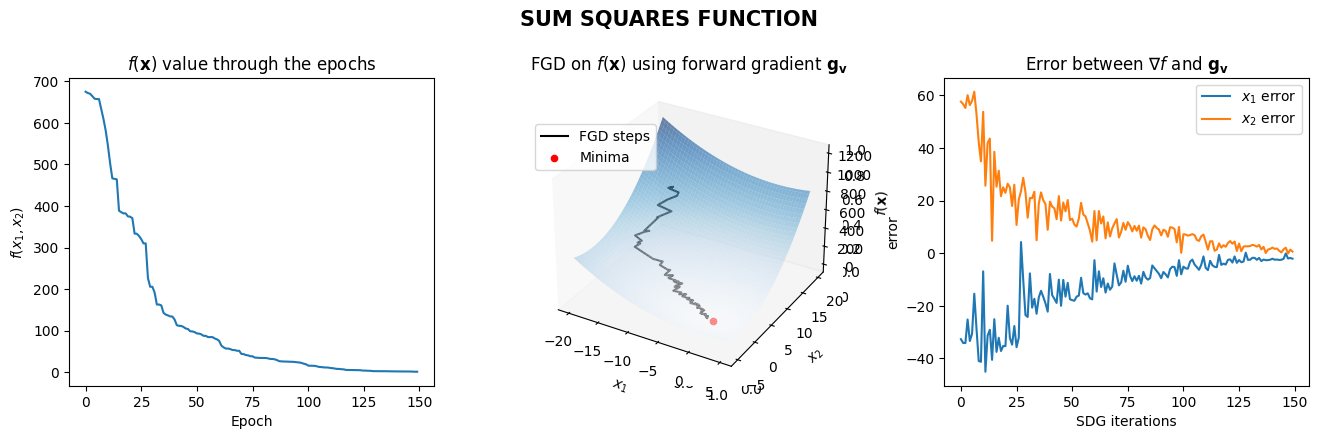

In [6]:
# Define the function
def f1(x1, x2):
    return x1**2 + 2*x2**2 
    
# Define primals (x1, x2) 
primals = (torch.tensor([-15.]), torch.tensor([15.]))

plot_fgd("SUM SQUARES FUNCTION", f1, primals, min=[0,0,0], l_rate=0.1, epochs=150)

Let's now try it on the [trid function](https://www.sfu.ca/~ssurjano/trid.html):

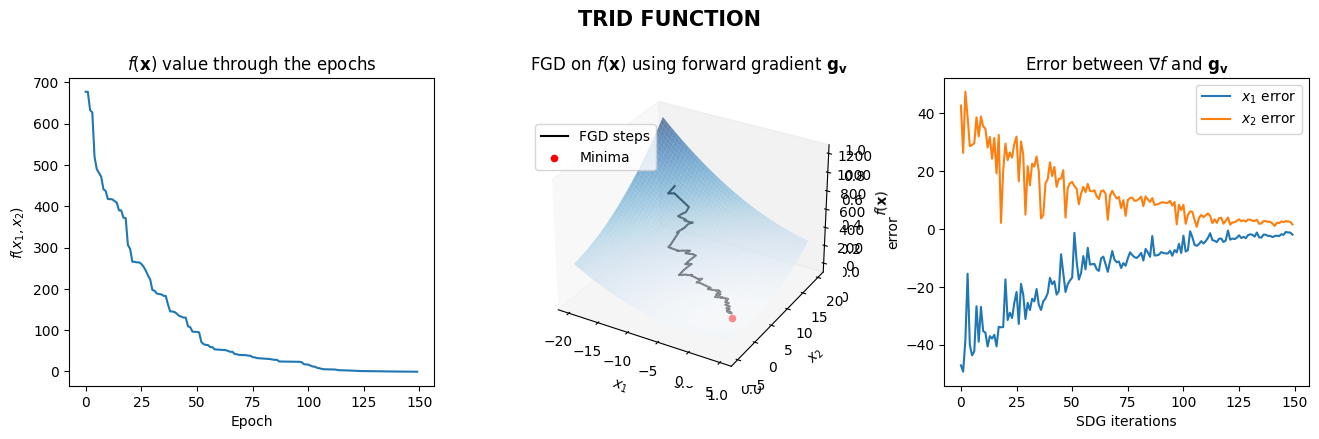

In [7]:
# Define the function
def f2(x1, x2):
    return (x1-1)**2 + (x2-1)**2 - x2*x1

# Define primals (x1, x2) 
primals = (torch.tensor([-15.]), torch.tensor([15.]))

plot_fgd("TRID FUNCTION", f2, primals, min=[2,2,-12], l_rate=0.1, epochs=150)

For the [booth function](https://www.sfu.ca/~ssurjano/booth.html) we get the following result:

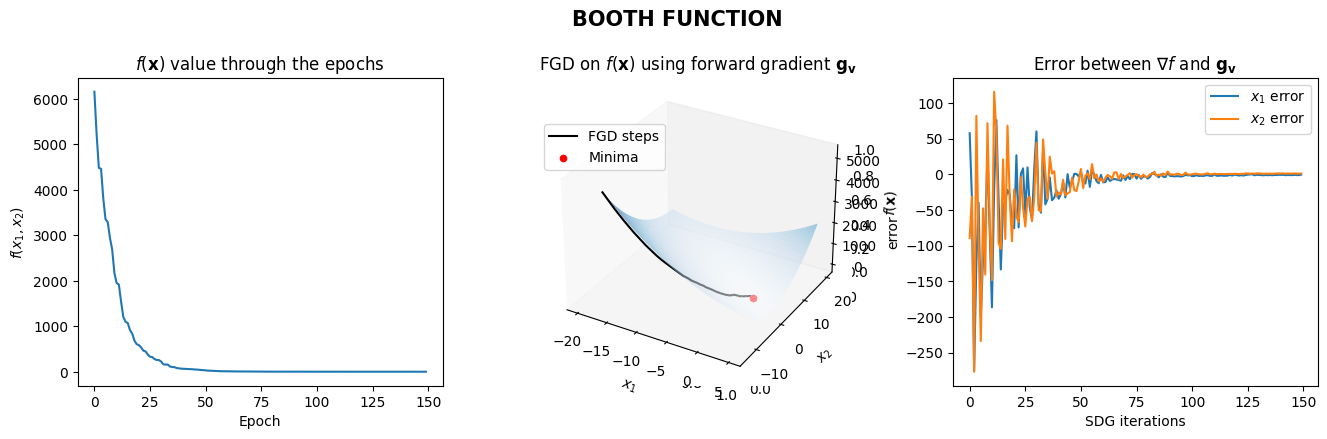

In [8]:
beta = 0.1

# Define the function
def f3(x1, x2):
    return (x1+2*x2-7)**2 + (2*x1+x2-5)**2

# Define primals (x1, x2) 
primals = (torch.tensor([-18.]), torch.tensor([-15.]))

plot_fgd("BOOTH FUNCTION", f3, primals, min=[1,3,0], l_rate=0.005, epochs=150)

---

Let's now try to apply the forward gradient to a FNN.

First, let's define a cross entropy 

In [11]:
def utils_cross_entropy(params, func, x, t):
    # Compute the prediction
    y_pred = func(params, x)
    # Compute the mean
    loss = F.cross_entropy(y_pred, t, reduction='mean')

    # Check correctness
    if not torch.equal(loss, nn.CrossEntropyLoss()(y_pred, t)): print("ERROR 34")
    return loss

Now let's define a simple FNN

In [12]:
# Define the neural network
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Our model will be trained using the iris dataset. This dataset will first be imported from *sklearn* library and than converted to be used in Pytorch:

In [13]:
# Load the iris dataset. Cinvert the numpy arrays to PyTorch tensors
iris = datasets.load_iris()
num_classes = len(iris.target_names)
X = torch.from_numpy(iris.data).float()
y = torch.from_numpy(iris.target).long()

# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TensorDatasets for training and test sets
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Define batch_size
batch_size = 3

# Create DataLoaders for training and test sets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Finally, let's train the network on the dataset. 

Before proceeding, it is important to comment on some sections of the code:
1. To extract the parameters of the model, we will use the *torch.make_functional* function, that given a *torch.nn.Module* extracts the state (params) and returns a functional version of the model.
2. For the perturbation vector, we will use the *torch.rand_like* function, that returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1 (exactly what we need).
3. The *utils_cross_entropy* will be used by the *functorch.jvp* function, that will input only primals and tangents to it. Since our cross entropy also requires "params" and "func" to be specified, we will need to use *functool.partial*: this function will create a new callable function that behave like cross entropy but has 2 positional arguments less (params and funct indeed). The missing arguments will be always substituted by the one specified when calling *functool.partial*.

Epoch 0, loss: 1.0263506174087524
Epoch 5, loss: 1.1228758096694946
Epoch 10, loss: 0.8765869736671448
Epoch 15, loss: 1.2752138376235962
Finished Training


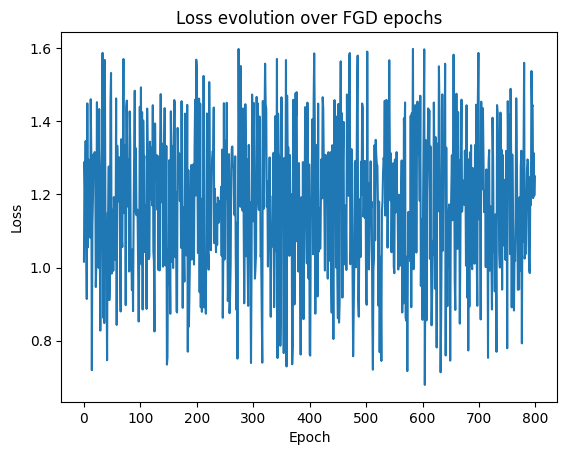

In [14]:
# Define the model
model = Net(input_size=4, output_size=3)

# Define the learning rate and the number of epochs
l_rate = 1e-1
num_epochs = 20

# Initialize empty loss list (to plot losses over epochs)
losses = list()

with torch.no_grad():
    # Get the functional version of the model with functorch
    func, params = functorch.make_functional(model)

    # Train the network with FGD (forward Gradient Descent)
    for epoch in range(num_epochs): 
        for i, (inputs, labels) in enumerate(train_dataloader):   
            # Create callable CE function
            f = functools.partial(utils_cross_entropy, func=func, x=inputs, t=labels)
            
            # Sample perturbation (for each parameter of the model)
            v_params = tuple([torch.randn_like(p) for p in params])  

            # Forward AD
            loss, jvp = functorch.jvp(f, (tuple(params),), (v_params,))
            losses.append(loss)

            # For each parameter
            for j, p in enumerate(params):
                # Compute forward gradient
                g = jvp * v_params[j]
                # Parameters update
                p = p - l_rate * g 
            
        if epoch % 5 == 0: print(f'Epoch {epoch}, loss: {losses[-1]}')

    print('Finished Training')

plt.title("Loss evolution over FGD epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)

### References

[1] [Derivative](https://en.wikipedia.org/wiki/Derivative).

[2] Kofi Asiedu Brempong, 2020 [I Finally Understood Backpropagation: And you can too...](https://towardsdatascience.com/i-finally-understood-backpropagation-and-you-can-too-44f7dd98ff52).

[3] Atılım Gunes Baydin, Barak A. Pearlmutter, Don Syme, Frank Wood, Philip Torr, 2022. [Gradients without Backpropagation](https://arxiv.org/abs/2005.00817).

[4] [Dual number](https://en.wikipedia.org/wiki/Dual_number).

[5] Mark Saroufim, 2019. [Automatic Differentiation Step by Step](https://marksaroufim.medium.com/automatic-differentiation-step-by-step-24240f97a6e6).

[6] Robert Lange, 2019. [Forward Mode Automatic Differentiation & Dual Numbers](https://towardsdatascience.com/forward-mode-automatic-differentiation-dual-numbers-8f47351064bf).

[7] [Automatic Differentiation in Machine Learning: a Survey](https://www.jmlr.org/papers/volume18/17-468/17-468.pdf).

[8] Daniel Worrall, 2021. [Dual numbers](https://danielewworrall.github.io/blog/2021/08/dual-numbers/)

[9] Dr. Robert Kübler, 2022. [Papers Simplified: Gradients without Backpropagation](https://towardsdatascience.com/papers-simplified-gradients-without-backpropagation-96e8533943fc).